# Plotting CMIP6 Data using Amazon Web Services
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the CMIP6 AWS Catalog](#load)

[Plot a Time Series](#time_series)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be reading in the database of Coupled Model Intercomparison Project phase 6 (CMIP6) output hosted by Amazon Web Services and exploring its contents. 

The steps in this tutorial build on the various skills we learned in previous tutorials:
- [Read in Data and Plot a Time Series](https://github.com/climate-datalab/Time-Series-Plots/blob/main/1.%20Read%20in%20Climate%20Data%20%2B%20Plot%20a%20Regionally%20Averaged%20Time%20Series.ipynb)
  (regional averaging, time series plotting)
  
- [Mean-State and Seasonal Average Maps](https://github.com/climate-datalab/Map-Plots/blob/main/2.%20Mean-State%20and%20Seasonal%20Difference%20Plots.ipynb)
  (concatenating xarray objects)

Basically: we'll be doing a lot of the same things we did in those tutorials, but accessing data via the cloud instead of downloading the files to a local machine/server! Please refer back to those materials if you would like additional detail.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes you're starting with an environment in which `intake`, `intake-esm`, and `s3fs` are already installed - for details on those packages, see tutorial 1.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs

<a id='load'></a> 
## **Load and Query the CMIP6 AWS Catalog**

Now we'll locate data from the same file used in previous tutorials. The example data file from the [Time Series Plots](https://github.com/climate-datalab/Time-Series-Plots) and [Map Plots](https://github.com/climate-datalab/Map-Plots) repositories is:

`tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc`

#### **Important characteristics of this file**:
- _Variable ("variable_id")_: This is a surface air temperature, or "tas", variable.
- _Realm ("table_id")_: Surface air temperature is generated by the atmosphere component of a climate model ("A"), and the information in this particular file is averaged monthly ("mon").
- _Model ("source_id")_: The name of the model is "CanESM5", which is short for the Canadian Earth System Model version 5.
- _Experiment ("experiment_id")_: The name of the model experiment being run. The file above is a _historical_ simulation: since we're also interested in the future projection information, we'll further specify that we'd also like the associated SSPs below.
- _Ensemble member ("member_id")_: The name of this ensemble member is "r10i1p1f1".

We first begin with opening the data catalog itself (_note - this step can be fairly slow_):

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

Now specify the appropriate search terms:

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas' 

As we did in tutorial 1, we now apply the `.search` functionality to retrieve the information we want, then convert it to a data frame that we can work with:

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp126,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


#### **Read information and store as an xarray object**:

Now we can read in the zarr stores containing the actual information (locations for which are specified in the `zstore` field of the data frame) and open them in xarray.

Here I'm reading in the historical and SSP370 information: if you want to see the other future projections, you can use the other entries in the `res` table.

In [5]:
# Read in the historical data file
hist_data = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_data = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})

/Users/samstevenson/opt/anaconda3/lib/python3.8/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


<a id='time_series'></a> 
## **Plot a Time Series**

Now that the data have been read in, we can use it to plot a time series. Let's redo the example from our [first tutorial](http://localhost:8888/lab/tree/Time-Series-Plots/1.%20Read%20in%20Climate%20Data%20%2B%20Plot%20a%20Regionally%20Averaged%20Time%20Series.ipynb): a regionally averaged temperature plot for New York City.

First, we'll *also* concatenate the historical and SSP information into a single xarray object, to make the plotting simpler:

In [6]:
# Concatenate historical and future projection data
canesm5_data = xr.concat([hist_data, ssp370_data], dim="time")

Recall that the CanESM5 uses a non-standard 365-day year (no leap years), and to get the plotting to work correctly we have to convert the time format to `datetime64`:

In [7]:
# Convert time to datetime64 format
time = canesm5_data.time.astype('datetime64[ns]')

Now we follow the rest of the steps from the previous tutorial to define lat/lon bounds, mask the data, and compute a regional average:

In [8]:
# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 40, 41.5
lon_min, lon_max = 285.5, 287

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_NYC_lat = (canesm5_data.lat >= lat_min) & (canesm5_data.lat <= lat_max)
tas_NYC_lon = (canesm5_data.lon >= lon_min) & (canesm5_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_NYC = canesm5_data.where(tas_NYC_lat & tas_NYC_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_NYC = tas_NYC.mean(dim=["lat", "lon"])

and finally, generate our plot!

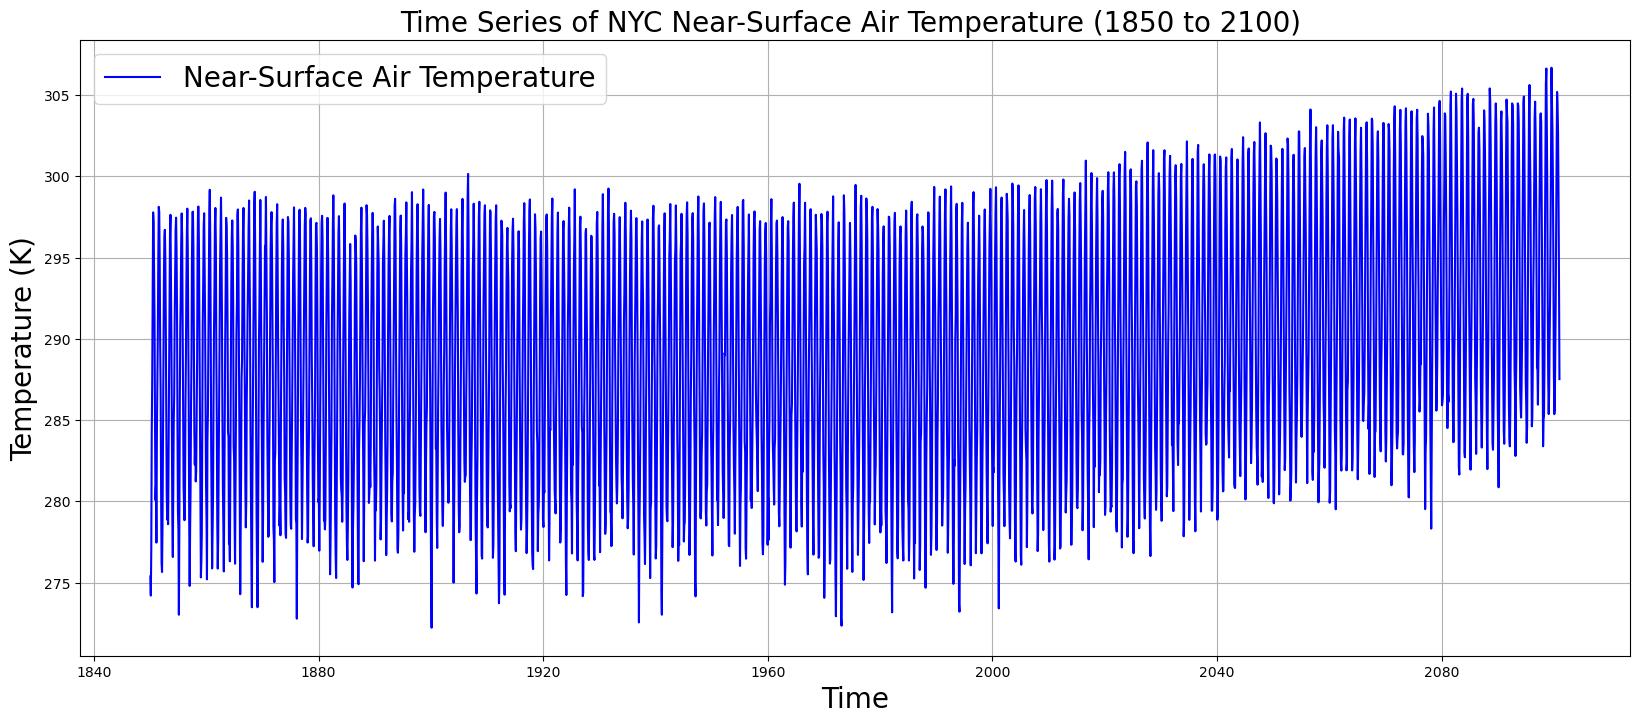

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, tas_NYC.tas, label='Near-Surface Air Temperature', color='b')
ax.set_title("Time Series of NYC Near-Surface Air Temperature (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

Yay! Now you can compare this plot to the one you generated in the original tutorial, and see what they look like (hint: the historical portions should be the same!)